<a href="https://colab.research.google.com/github/yeseniaandrade/yeseniaandrade-IS_4487_Tokyo/blob/main/YeseniaAndradeCopy_of_day8_lab_evaluate_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 8 Lab, IS 4487

What do you need to know how to do for today's project?

1. Fit a tree model using all the available predictors.
2. Create a confusion matrix  and identify numbers of TP, FP, TN and FN.
3. Estimate profit (benefits - costs) using a defined cost-benefit matrix and a confusion matrix for:
  - all customers
  - only the customer predicted to answer

Of course, for this lab we'll be using the MegaTelCo data, in which case the target is `leave` not `answer`.  

Note that the first set of steps below is identical to what we did in the previous lab.




#Load Libraries


In [1]:
# Import packages needed for the classification tree
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz # Import Decision Tree Classifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Get Data


In [2]:
mtc = pd.read_csv("https://raw.githubusercontent.com/jefftwebb/is_4487_base/dd870389117d5b24eee7417d5378d80496555130/Labs/DataSets/megatelco_leave_survey.csv")

# Clean data

Perform the cleaning from the previous labs:

- Make a copy of the data
- Remove negative values of income and house
- Remove absurdly large value of handset_price
- Remove NAs
- Change college to yes and no
- Make string variables into categorical variables.
- Convert the now ordered categorical levels into integers.


In [3]:
# Make explicit copy
mtc_clean = mtc.copy()

# filter rows
mtc_clean = mtc[(mtc['house'] > 0) & (mtc['income'] > 0) & (mtc['handset_price'] < 1000)]

# remove NAs
mtc_clean = mtc_clean.dropna()

# Recode college
mtc_clean['college'] = mtc_clean['college'].replace({'one': 'yes', 'zero': 'no'})

# change reported usage and reported satisfaction (ordered)
mtc_clean['college'] = pd.Categorical(mtc_clean['college'],
                                    ordered = False).codes

mtc_clean['considering_change_of_plan'] = pd.Categorical(mtc_clean['considering_change_of_plan'],
                                    ordered = False).codes

# change reported usage and reported satisfaction (ordered)
mtc_clean['reported_usage_level'] = pd.Categorical(mtc_clean['reported_usage_level'],
                                    categories = ['low', 'avg','high'],
                                    ordered = True).codes

mtc_clean['reported_satisfaction'] = pd.Categorical(mtc_clean['reported_satisfaction'],
                                    categories = ['low', 'avg','high'],
                                    ordered = True).codes




# Fit full model

1. Split the data into train and test sets
2. Fit the model to the train set using `max_depth = 4` to keep the tree simple and prevent overfitting.

In [4]:
# 1. divide mtc_clean into train and test
train = mtc_clean.sample(frac=0.8, random_state=200) # 80% of data for training
test = mtc_clean.drop(train.index) # the remaining 20%


# 2. Define X and y in train and test
X_train = train.drop(['id', 'leave'], axis = 1)
y_train = train['leave']

X_test = test.drop(['id', 'leave'], axis = 1)
y_test = test['leave']

# 3.  Initialize model, specifying max_depth = 4
full_tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 4)

# 4. Fit model to train data
full_tree = full_tree.fit(X_train, y_train)

# Create a confusion matrix

The confusion matrix will show counts of false positives, true positives, false negatives and true negatives. Essentially it provides a window into how the model is performing--where it is making mistakes.

Remember that the confusion matrix will display TP, FP, TN and FN *on the test set*.  Thus:

1. Fit the model on the train set
2. Evaluate the model on test set



In [5]:
# Get model predictions
pred = full_tree.predict(X = X_test)


In [6]:
pred[0:5,]

array(['STAY', 'LEAVE', 'LEAVE', 'LEAVE', 'LEAVE'], dtype=object)

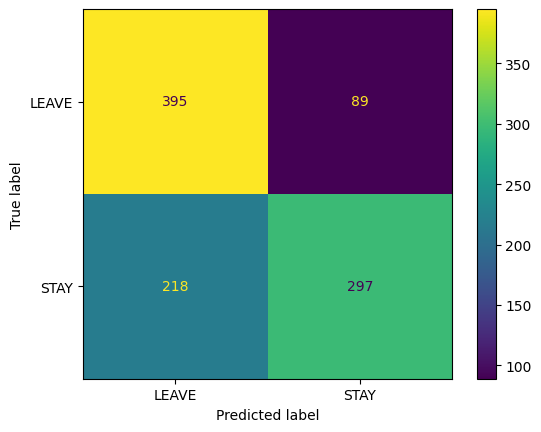

In [7]:
# create a confusion matrix using the Display.from_predictions function
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, pred)

Explanation of code:

- `ConfusionMatrixDisplay.from_predictions(y, pred)`: creates a confusion matrix in a heatmap format.

It is typical to put the predictions in the columns.  But what matters is that you are able to identify the following categories--and associated counts-- from the table:

- TP--predicted to leave and actually left:  395
- FP--predicted to leave but stayed:  218
- TN--predicted to stay and stayed: 297
- FN--predicted to stay but left: 89   

These numbers are related to accuracy.  (TP + TN)/ total = accuracy.  

Go ahead and do the calculations.

In [9]:
# Calculate accuracy from the confusion matrix
accuracy = (395 + 297) / (395 + 218 + 297 + 89)
print(accuracy)

0.6926926926926927


In [10]:
# Verify by comparing test predictions and test observations using the code
# from previous labs
sum(pred == y_test) / len(y_test)


0.6926926926926927

# Calculate Profit

Using the above confusion matrix how much profit (revenue - costs) could be expected with the following costs-benefits?

For MegaTelCo we will assume:
- benefit (revenue) = 800
- cost = 200  

TPs are a benefit, FPs are a cost. Again, we ignore those predicted to stay.

Why do we ignore those who are predicted to stay??

Note that the cost-benefit numbers will be different in the AdviseInvest case! Costs and benefits are very context dependent.

Why are TPs a benefit? In the MegaTelCo scenario, these are customers who are predicted to leave and actually were going to leave. If your marketing campaign is successful, then you can convince them to stay, thereby saving the company money. (In the AdviseInvest scenario the situation is a little different. TPs are customers that you have predicted will answer the phone and do answer, thus providing an opportunity for your sales reps to make a sale.)

**Assume you can save 100% of the people who were actually going to leave.**

Here is the calculation:

- Multiply TP (the true leavers) x 600 (benefit - cost).  These are the leave-leave people in the confusion matrix who would have been  retained due to your marketing campaign.
- Multiply FP (the false leavers) x 200 (cost). These are the leave-stay people in the confusion matrix who churned. They got the offer but were going to stay anyway.  You wasted your money.

In [11]:
# Calculate profit for targeting only those predicted to leave
profit_targeted = 395 * (800 - 200) - 218 * 200
print(profit_targeted)

193400


So, this strategy would show a profit.  But we need to compare this against the default strategy not using a model at all, which would entail marketing to all customers.

What would profit be in that case?

In [13]:
# Calculate profit for targeting everyone
y_test.value_counts()

484*600-200*515
# hint: use the proportion of leavers and stayers in test
y_test.value_counts()


leave
STAY     515
LEAVE    484
Name: count, dtype: int64

Which strategy will show more profit: targeting everyone or targeting only those predicted to leave?

# Adjust the decision threshold

As discussed in the lecture, we can adjust the class decision threshold up or down to shift the numbers around in the confusion matrix.  This will impact profit.

So far we have used the default for classifying the positive class: the majority, meaning a probability of .5 or greater.

Let's try a threshold of .7.

1. Predict probabilities rather than a label, again using the test set. We will use the awkwardly named function `predict_proba().` This returns a two column numpy array, with two probabilities for each observation.

In [14]:
# Predict probabilities for X_test
pred_prob = full_tree.predict_proba(X = X_test)

# Check that it worked
pred_prob[:5,]

array([[0.15291262, 0.84708738],
       [0.77182236, 0.22817764],
       [0.67639257, 0.32360743],
       [0.77182236, 0.22817764],
       [0.52884615, 0.47115385]])



2. Turn the probabilities > .7 into a `LEAVE` for use in the confusion matrix. For this operation we'll use the `where()` function from numpy. `pred_prob` is an array with two columns. We'll need to be sure to use the first column.  Why first? the order corresponds to the order of the levels in `leave`, which is alphabetic, with `LEAVE` first.

In [17]:
pred_labels = np.where(pred_prob[:,0] > 0.7, "LEAVE", "STAY")
pred_labels[0:5,]

array(['STAY', 'LEAVE', 'STAY', 'LEAVE', 'STAY'], dtype='<U5')

Code explanation:

- `pred_prob[:,0]`: This is array indexing in NumPy. `:` means "all rows." `0` means "first column" (remember, indexing starts at 0)

- `pred_prob[:,0] > 0.7`: This creates a boolean array, comparing each value in the selected column to 0.7.

- `np.where()`: This is a NumPy function that works like `IF` in Excel to return elements chosen from two options based on a condition. It takes three arguments: condition, x, y.  Where the condition (`pred_prob[:,0] > 0.7`) is True, "LEAVE" will be used. Where the condition is False, "STAY" will be used.

3. Calculate profit using `pred_labels`

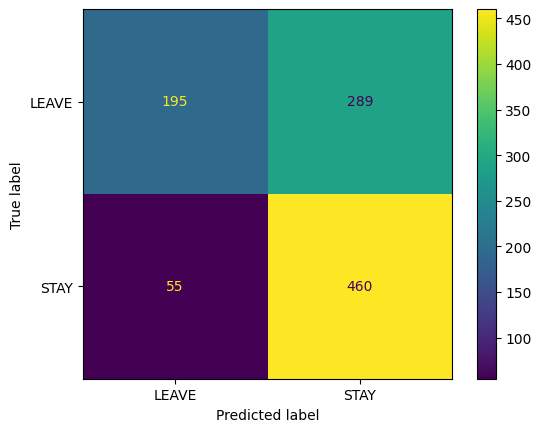

In [16]:
# Create a confusion matrix using these new labels

ConfusionMatrixDisplay.from_predictions(y_test, pred_labels)

In [23]:
# Calculate profit
(800-200) * 195 - (200*55)

106000

# Your Turn:

Try a threshold of .3.

In [19]:
# Predict probabilities for X_test
pred_prob = full_tree.predict_proba(X = X_test)
pred_prob[:5,]

array([[0.15291262, 0.84708738],
       [0.77182236, 0.22817764],
       [0.67639257, 0.32360743],
       [0.77182236, 0.22817764],
       [0.52884615, 0.47115385]])

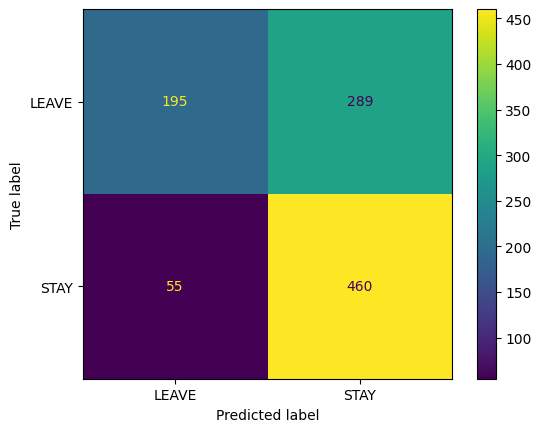

In [20]:
# Create a confusion matrix using these new labels
ConfusionMatrixDisplay.from_predictions(y_test, pred_labels)

In [24]:
# Calculate profit
(800-200) * 440 - (200 *347)

194600

**Make a comment.**

Compare this strategy with:
1. targeting everyone
2. targeting .5 and above
3. targeting .7 and above

# Mini Project

Using the Default data for yesterday's lab create a profit matrix for 3 different class decision thresholds:  .2, .5 and .7.

Cost:  100 dollars to restructure the loan.

Benefit: 1000 to prevent the default.

Note: this will entail fitting a model and predicting for a test set.

In [ ]:
d = pd.read_csv("https://raw.githubusercontent.com/jefftwebb/IS_4487_Tokyo/main/Default.csv")


**Comment**: which class decision threshold is best for optimzing the company's profit?